In [4]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# Load IMDb dataset
imdb_dataset = load_dataset('imdb')
train_dataset = imdb_dataset['train']
test_dataset = imdb_dataset['test']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_dataset = imdb_dataset['train']
test_dataset = imdb_dataset['test']


In [ ]:
import pandas as pd

# Convert training data to DataFrame
train_df = pd.DataFrame(train_dataset)

# Convert test data to DataFrame
test_df = pd.DataFrame(test_dataset)


In [ ]:
train_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [ ]:
test_df.count()

text     25000
label    25000
dtype: int64

In [ ]:
train_df.label.value_counts()

0    12500
1    12500
Name: label, dtype: int64

Here we got a balanced dataset with equal number of 0 and 1 labels.


In [ ]:
train_df['token_length'] = train_df.text.progress_apply(lambda x: len(x.split()))

100%|██████████| 25000/25000 [00:00<00:00, 61689.58it/s]


In [ ]:
data_pos = train_df[train_df['label'] == 1]
data_pos['token_length'].describe()

count    12500.000000
mean       236.706560
std        180.485743
min         12.000000
25%        125.000000
50%        174.000000
75%        291.000000
max       2470.000000
Name: token_length, dtype: float64

For positive reviews, we have maximum token 2470 and minimum token 12. While the average token is 236.

In [ ]:
data_neg = train_df[train_df['label'] == 0]
data_neg['token_length'].describe()

count    12500.000000
mean       230.867840
std        166.663126
min         10.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

And for negative reviews, we have maximum and minimum token respectively 1522 and 10. While the average token is 230.

<Figure size 500x800 with 0 Axes>

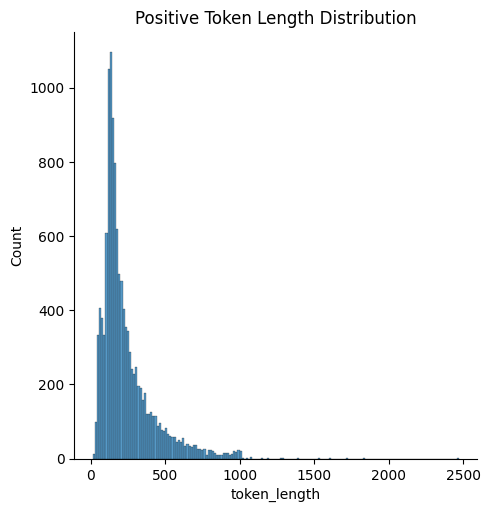

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_pos, x='token_length')
plt.title('Positive Token Length Distribution')
plt.show()

<Figure size 500x800 with 0 Axes>

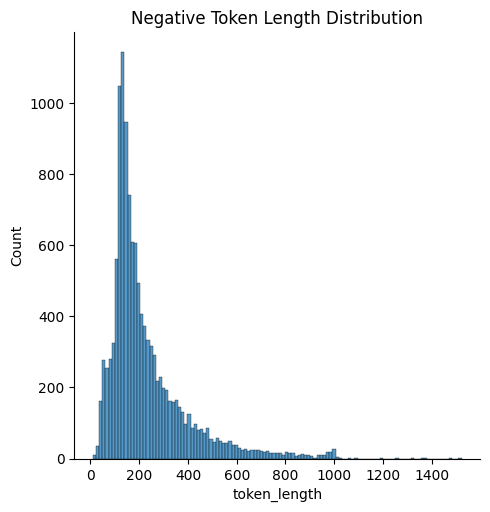

In [ ]:
plt.figure(figsize=(5, 8))
sns.displot(data_neg, x='token_length')
plt.title('Negative Token Length Distribution')
plt.show()

In [ ]:
print('Positive')
print(data_pos[data_pos['token_length'] == data_pos['token_length'].min()]['text'].item())
print()
print('Negative')
print(data_neg[data_neg['token_length'] == data_neg['token_length'].min()]['text'].tolist())

Positive
Adrian Pasdar is excellent is this film. He makes a fascinating woman.

Negative
["I wouldn't rent this one even on dollar rental night.", 'This movie is terrible but it has some good effects.']


===================================================================================================================

In [1]:
!pip install nltk


In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')  # If using lemmatization


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [46]:
from collections import Counter
import torch
from torchtext.data.utils import get_tokenizer
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import torch
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
import nltk

nltk.download('punkt')


imdb_dataset = load_dataset('imdb')
train_dataset = imdb_dataset['train']
test_dataset = imdb_dataset['test']

apply_stemming = False
apply_lemmatization = True

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text, apply_stemming=False, apply_lemmatization=False):
    tokens = word_tokenize(text)
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]
    if apply_lemmatization:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

def filter_reviews(dataset, word_count_min=100, word_count_max=500):
    filtered_texts = []
    filtered_labels = []
    for item in dataset:
        tokens = preprocess_text(item['text'], apply_stemming, apply_lemmatization)
        if word_count_min <= len(tokens) <= word_count_max:
            filtered_texts.append(tokens)
            filtered_labels.append(item['label'])
    return filtered_texts, filtered_labels


train_texts, train_labels = filter_reviews(train_dataset, 100, 500)
test_texts, test_labels = filter_reviews(test_dataset, 100, 500)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
all_tokens = [token for review in train_texts for token in review]
vocab = {word: i+2 for i, word in enumerate(set(all_tokens))}  # Starting index from 2 for special tokens

# Add special tokens to the vocabulary
vocab['<pad>'] = 0
vocab['<unk>'] = 1
unknown_index = vocab['<unk>']


class IMDBRNNDataSet(Dataset):
    def __init__(self, texts, labels, word_to_index):
        # Map words to indices, defaulting to '<unk>' index for unknown words
        self.texts = [[word_to_index.get(word, word_to_index['<unk>']) for word in text] for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)



In [51]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    texts, labels = zip(*batch)
    # Pad sequences to the maximum length in the batch
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab['<pad>'])
    labels = torch.tensor(labels, dtype=torch.float)
    return texts, labels

train_rnn_dataset = IMDBRNNDataSet(train_texts, train_labels, vocab)
val_rnn_dataset = IMDBRNNDataSet(val_texts, val_labels, vocab)
test_rnn_dataset = IMDBRNNDataSet(test_texts, test_labels, vocab)

train_loader = DataLoader(train_rnn_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_rnn_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_rnn_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

print("DataLoaders for training, validation, and test are ready!")


DataLoaders for training, validation, and test are ready!


In [ ]:
# ================================================RNN==========================================================================

In [34]:
#1. Model RNN
import torch
import torch.nn as nn

class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        # Apply dropout to the hidden state from the last layer
        hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)


In [35]:
#2. Train and eval
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for texts, labels in iterator:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for texts, labels in iterator:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [36]:
#3. Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = len(vocab) + 2 # +2 for <pad> and <unk> tokens
EMBEDDING_DIM = 100
HIDDEN_DIM = 512
OUTPUT_DIM = 1
NUM_LAYERS = 2
DROPOUT = 0.5

model = SentimentRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss().to(device)



In [25]:
# using lemmatization
#4. Calling functions
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {val_loss:.4f}, Val. Acc: {val_acc*100:.2f}%')


Epoch: 1, Train Loss: 0.7228, Train Acc: 49.83%, Val. Loss: 0.6956, Val. Acc: 49.73%
Epoch: 2, Train Loss: 0.7075, Train Acc: 50.40%, Val. Loss: 0.7013, Val. Acc: 50.37%
Epoch: 3, Train Loss: 0.7055, Train Acc: 50.08%, Val. Loss: 0.7083, Val. Acc: 49.82%
Epoch: 4, Train Loss: 0.7046, Train Acc: 50.95%, Val. Loss: 0.7002, Val. Acc: 49.71%
Epoch: 5, Train Loss: 0.7039, Train Acc: 50.78%, Val. Loss: 0.6987, Val. Acc: 50.21%


In [37]:
# without using stemming or lemmatization
#4. Calling functions
EPOCHS = 5
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {val_loss:.4f}, Val. Acc: {val_acc*100:.2f}%')


Epoch: 1, Train Loss: 0.7242, Train Acc: 49.37%, Val. Loss: 0.6932, Val. Acc: 50.63%
Epoch: 2, Train Loss: 0.7073, Train Acc: 50.02%, Val. Loss: 0.6929, Val. Acc: 50.50%
Epoch: 3, Train Loss: 0.7051, Train Acc: 51.19%, Val. Loss: 0.7087, Val. Acc: 49.45%
Epoch: 4, Train Loss: 0.7021, Train Acc: 50.64%, Val. Loss: 0.6945, Val. Acc: 49.47%
Epoch: 5, Train Loss: 0.7047, Train Acc: 50.27%, Val. Loss: 0.6930, Val. Acc: 50.63%


## Observations:
* Using Lemmatization or not using it, doesnt make any difference in the performance of the RNN.
* The accuracy on both the training and validation sets is hovering around 50%, which is close to random guessing for a binary classification task. This suggests that the model struggles to learn meaningful patterns from the data.
* Basic RNNs are known to struggle with long-term dependencies due to issues like vanishing gradients. This characteristic might limit the model's ability to capture relevant information from movie reviews, which can be relatively long texts.



1. **Vanishing Gradient Problem**: LSTMs mitigate the vanishing gradient issue common in RNNs, enabling them to learn effectively over long sequences.
2. **Long-Term Dependencies**: Unlike RNNs, LSTMs can capture long-term dependencies in sequence data, making them superior for tasks requiring historical context.
3. **Selective Memory**: LSTMs have gating mechanisms that allow selective retention and forgetting of information, providing nuanced control over memory.
4. **Empirical Performance**: LSTMs generally outperform RNNs on a variety of sequence modeling tasks, as demonstrated by empirical results across numerous applications.

## **That is why we will be switching to LSTM to get greater accuracy.**

===================================================================================================================

## Last Output Vs Mean of all Outputs

In [61]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1, dropout=0.5, output_strategy='last'):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=(0 if num_layers == 1 else dropout))
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.output_strategy = output_strategy

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, _) = self.lstm(embedded)

        if self.output_strategy == 'mean':
            # Mean of all outputs
            hidden = torch.mean(output, dim=1)
        else:  # 'last'
            # Only the last output
            hidden = output[:, -1, :]

        hidden = self.dropout(hidden)
        return self.fc(hidden)


In [15]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for texts, labels in iterator:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()

    with torch.no_grad():
        for texts, labels in iterator:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts).squeeze(1)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = len(vocab) + 2
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 2
DROPOUT = 0.5


model_last = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                           num_layers=NUM_LAYERS, dropout=DROPOUT,
                           output_strategy='last').to(device)

model_mean = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM,
                           num_layers=NUM_LAYERS, dropout=DROPOUT,
                           output_strategy='mean').to(device)


In [17]:
EPOCHS = 5

# For the model using the last output
optimizer_last = optim.Adam(model_last.parameters())
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model_last, train_loader, optimizer_last, criterion)
    val_loss, val_acc = evaluate(model_last, val_loader, criterion)
    print(f'[Last Output] Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {val_loss:.4f}, Val. Acc: {val_acc*100:.2f}%')

# For the model using the mean of outputs
optimizer_mean = optim.Adam(model_mean.parameters())
for epoch in range(EPOCHS):
    train_loss, train_acc = train(model_mean, train_loader, optimizer_mean, criterion)
    val_loss, val_acc = evaluate(model_mean, val_loader, criterion)
    print(f'[Mean Output] Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {val_loss:.4f}, Val. Acc: {val_acc*100:.2f}%')


[Last Output] Epoch: 1, Train Loss: 0.6941, Train Acc: 50.27%, Val. Loss: 0.6932, Val. Acc: 50.71%
[Last Output] Epoch: 2, Train Loss: 0.6933, Train Acc: 50.79%, Val. Loss: 0.6929, Val. Acc: 50.66%
[Last Output] Epoch: 3, Train Loss: 0.6928, Train Acc: 50.95%, Val. Loss: 0.6943, Val. Acc: 50.71%
[Last Output] Epoch: 4, Train Loss: 0.6921, Train Acc: 51.80%, Val. Loss: 0.7001, Val. Acc: 50.66%
[Last Output] Epoch: 5, Train Loss: 0.6923, Train Acc: 51.58%, Val. Loss: 0.6934, Val. Acc: 50.63%
[Mean Output] Epoch: 1, Train Loss: 0.6103, Train Acc: 65.30%, Val. Loss: 0.4747, Val. Acc: 78.97%
[Mean Output] Epoch: 2, Train Loss: 0.3863, Train Acc: 83.61%, Val. Loss: 0.3416, Val. Acc: 85.75%
[Mean Output] Epoch: 3, Train Loss: 0.2583, Train Acc: 89.71%, Val. Loss: 0.3032, Val. Acc: 87.45%
[Mean Output] Epoch: 4, Train Loss: 0.1706, Train Acc: 93.72%, Val. Loss: 0.3354, Val. Acc: 87.33%
[Mean Output] Epoch: 5, Train Loss: 0.1056, Train Acc: 96.26%, Val. Loss: 0.3482, Val. Acc: 87.89%


## Using the Last Output
The model that uses only the last output of the LSTM layer achieves around 50-51% accuracy on both the training and validation datasets. This performance is close to random guessing for a binary classification task, indicating that the model is not learning effectively from the data.
## Using the Mean of All Outputs
The model that uses the mean of all outputs shows a significant improvement over the model using the last output. Starting from the first epoch, it achieves a training accuracy of 65.30% and a validation accuracy of 78.97%, which improve to 96.26% and 87.89% by the fifth epoch, respectively.

## Conclusion:
The mean output strategy appears to be far more effective for this task. This suggests that important features for sentiment analysis are distributed throughout the text, and averaging the outputs helps the model to integrate this information more effectively.

## **So going forward we will use LSTM with Mean of all Outputs combination.**


===================================================================================================================

# Hyperparameter Tuning and logging using wandb

In [55]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00


In [56]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [57]:
# import wandb
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.metrics import accuracy_score
# import numpy as np

# # Initialize wandb
# wandb.init(project="SMAI-Q3-IMDB", config={
#     "embedding_dim": 100,  # Placeholder, will be set in the loop
#     "hidden_dim": 256,     # Placeholder
#     "learning_rate": 0.001,# Placeholder
#     "batch_size": 32,      # Placeholder
#     "epochs": 5,
# })

# # Assuming CUDA is available, configure CUDA
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


wandb: Currently logged in as: rhitesh-ksingh99. Use `wandb login --relogin` to force relogin


In [64]:
import wandb
import torch.optim as optim
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader


def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_acc = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs.squeeze(), labels)
        preds = torch.sigmoid(outputs).cpu().detach().numpy().round()
        acc = accuracy_score(labels.cpu().numpy(), preds)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)

    wandb.log({"train_loss": avg_loss, "train_accuracy": avg_acc})

    return avg_loss, avg_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels)
            preds = torch.sigmoid(outputs).cpu().detach().numpy().round()
            acc = accuracy_score(labels.cpu().numpy(), preds)

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(loader)
    avg_acc = total_acc / len(loader)

    wandb.log({"val_loss": avg_loss, "val_accuracy": avg_acc})

    return avg_loss, avg_acc




In [62]:
VOCAB_SIZE = len(vocab) + 2
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
NUM_LAYERS = 2
DROPOUT = 0.5

In [65]:
hyperparams = [
    {"embedding_dim": 100, "hidden_dim": 256, "learning_rate": 0.001, "batch_size": 32, "epochs": 5},
    {"embedding_dim": 200, "hidden_dim": 256, "learning_rate": 0.001, "batch_size": 64, "epochs": 5},
    {"embedding_dim": 100, "hidden_dim": 128, "learning_rate": 0.0005, "batch_size": 32, "epochs": 5},
    {"embedding_dim": 200, "hidden_dim": 128, "learning_rate": 0.0005, "batch_size": 64, "epochs": 5},
    {"embedding_dim": 100, "hidden_dim": 256, "learning_rate": 0.002, "batch_size": 32, "epochs": 5},
]

for config in hyperparams:
    wandb.init(project="SMAI-Q3-IMDB", config=config)
    config = wandb.config

    train_loader = DataLoader(train_rnn_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_rnn_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_rnn_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

    model = SentimentLSTM(VOCAB_SIZE, config.embedding_dim, config.hidden_dim, OUTPUT_DIM, NUM_LAYERS, DROPOUT, output_strategy='mean').to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    for epoch in range(1, config.epochs + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    wandb.log({"test_loss": test_loss, "test_acc": test_acc})

    wandb.finish()


epoch,▁▃▅▆█
test_acc,▁
test_loss,▁
train_acc,▁▅▇▇█
train_accuracy,▁▅▇▇█
train_loss,██▅▅▃▃▂▂▁▁
val_acc,▁▇▇██
val_accuracy,▁▇▇██▅
val_loss,▆▆▁▁▂▂▂▂▃▃█
epoch,5
test_acc,0.80493


epoch,▁▃▅▆█
test_acc,▁
test_loss,▁
train_acc,▁▁▄▇█
train_accuracy,▁▁▄▇█
train_loss,████▇▇▃▃▁▁
val_acc,▁▃▇██
val_accuracy,▁▃▇███
val_loss,████▂▂▁▁▁▁▁
epoch,5
test_acc,0.85368


epoch,▁▃▅▆█
test_acc,▁
test_loss,▁
train_acc,▁▅▇▇█
train_accuracy,▁▅▇▇█
train_loss,██▅▅▃▃▂▂▁▁
val_acc,▁▄▇██
val_accuracy,▁▄▇██▆
val_loss,██▄▄▂▂▁▁▁▁▄
epoch,5
test_acc,0.84168


epoch,▁▃▅▆█
test_acc,▁
test_loss,▁
train_acc,▁▅▆▇█
train_accuracy,▁▅▆▇█
train_loss,██▅▅▃▃▂▂▁▁
val_acc,▁▅▇▇█
val_accuracy,▁▅▇▇█▇
val_loss,██▄▄▁▁▁▁▂▂▃
epoch,5
test_acc,0.84819


epoch,▁▃▅▆█
test_acc,▁
test_loss,▁
train_acc,▁▂▆▇█
train_accuracy,▁▂▆▇█
train_loss,████▄▄▂▂▁▁
val_acc,▁▃▇██
val_accuracy,▁▃▇███
val_loss,██▇▇▂▂▁▁▂▂▃
epoch,5
test_acc,0.85173


## Observations:
Lstm model with mean of all outputs and hyperparameters with
* batch_size:64
* embedding_dim:200
* epochs:5
* hidden_dim:256
* learning_rate:0.001

gives the greatest accuracy on test set with 0.8536794354838709.

To check out all the plots and visualization, https://wandb.ai/rhitesh-ksingh99/SMAI-Q3-IMDB?nw=nwuserrhiteshksingh99